
<a id='career'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search IV: Modeling Career Choice


<a id='index-0'></a>

## Contents

- [Job Search IV: Modeling Career Choice](#Job-Search-IV:-Modeling-Career-Choice)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Next we study a computational problem concerning career and job choices.

The model is originally due to Derek Neal [[Nea99]](../zreferences.html#neal1999).

This exposition draws on the presentation in [[LS18]](../zreferences.html#ljungqvist2012), section 6.5.

### Model features

- Career and job within career both chosen to maximize expected discounted wage flow.  
- Infinite horizon dynamic programming with two state variables.  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.6.0")
# uncomment to force package installation and precompilation
# github_project("QuantEcon/quantecon-notebooks-julia", version="0.6.0", instantiate=true, precompile = true)

In [2]:
using LinearAlgebra, Statistics

## Model

In what follows we distinguish between a career and a job, where

- a *career* is understood to be a general field encompassing many possible jobs, and  
- a *job*  is understood to be a position with a particular firm  


For workers, wages can be decomposed into the contribution of job and career

- $ w_t = \theta_t + \epsilon_t $, where  
  
  - $ \theta_t $ is contribution of career at time $ t $  
  - $ \epsilon_t $ is contribution of job at time $ t $  
  


At the start of time $ t $, a worker has the following options

- retain a current (career, job) pair $ (\theta_t, \epsilon_t) $
  — referred to hereafter as “stay put”  
- retain a current career $ \theta_t $ but redraw a job $ \epsilon_t $
  — referred to hereafter as “new job”  
- redraw both a career $ \theta_t $ and a job $ \epsilon_t $
  — referred to hereafter as “new life”  


Draws of $ \theta $ and $ \epsilon $ are independent of each other and
past values, with

- $ \theta_t \sim F $  
- $ \epsilon_t \sim G $  


Notice that the worker does not have the option to retain a job but redraw
a career — starting a new career always requires starting a new job.

A young worker aims to maximize the expected sum of discounted wages.


<a id='equation-exw'></a>
$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t w_t \tag{1}
$$

subject to the choice restrictions specified above.

Let $ V(\theta, \epsilon) $ denote the value function, which is the
maximum of [(1)](#equation-exw) over all feasible (career, job) policies, given the
initial state $ (\theta, \epsilon) $.

The value function obeys

$$
V(\theta, \epsilon) = \max\{I, II, III\},
$$

where


<a id='equation-eyes'></a>
$$
\begin{aligned}
& I = \theta + \epsilon + \beta V(\theta, \epsilon) \\
& II = \theta + \int \epsilon' G(d \epsilon') + \beta \int V(\theta, \epsilon') G(d \epsilon') \nonumber \\
& III = \int \theta' F(d \theta') + \int \epsilon' G(d \epsilon') + \beta \int \int V(\theta', \epsilon') G(d \epsilon') F(d \theta') \nonumber
\end{aligned} \tag{2}
$$

Evidently $ I $, $ II $ and $ III $ correspond to “stay put”, “new job” and “new life”, respectively.

### Parameterization

As in [[LS18]](../zreferences.html#ljungqvist2012), section 6.5, we will focus on a discrete version of the model, parameterized as follows:

- both $ \theta $ and $ \epsilon $ take values in the set `linspace(0, B, N)` — an even grid of $ N $ points between $ 0 $ and $ B $ inclusive  
- $ N = 50 $  
- $ B = 5 $  
- $ \beta = 0.95 $  


The distributions $ F $ and $ G $ are discrete distributions
generating draws from the grid points `linspace(0, B, N)`.

A very useful family of discrete distributions is the Beta-binomial family,
with probability mass function

$$
p(k \,|\, n, a, b)
= {n \choose k} \frac{B(k + a, n - k + b)}{B(a, b)},
\qquad k = 0, \ldots, n
$$

Interpretation:

- draw $ q $ from a β distribution with shape parameters $ (a, b) $  
- run $ n $ independent binary trials, each with success probability $ q $  
- $ p(k \,|\, n, a, b) $ is the probability of $ k $ successes in these $ n $ trials  


Nice properties:

- very flexible class of distributions, including uniform, symmetric unimodal, etc.  
- only three parameters  


Here’s a figure showing the effect of different shape parameters when $ n=50 $.


<a id='beta-binom'></a>

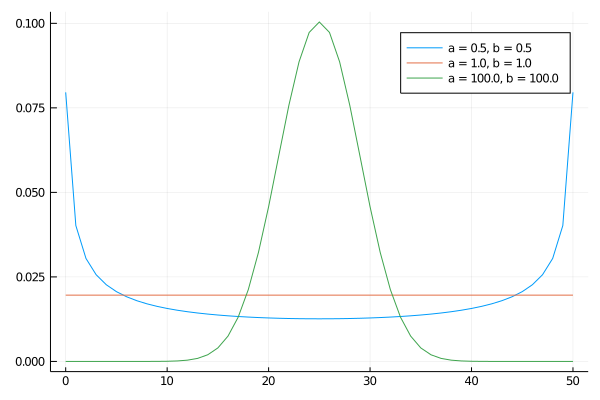

In [3]:
using Plots, QuantEcon, Distributions
gr(fmt=:png);

n = 50
a_vals = [0.5, 1, 100]
b_vals = [0.5, 1, 100]

plt = plot()
for (a, b) in zip(a_vals, b_vals)
    ab_label = "a = $a, b = $b"
    dist = BetaBinomial(n, a, b)
    plot!(plt, 0:n, pdf.(dist, support(dist)), label = ab_label)
end
plt

Implementation:

The code for solving the DP problem described above is found below:

In [4]:
function CareerWorkerProblem(;β = 0.95,
                             B = 5.0,
                             N = 50,
                             F_a = 1.0,
                             F_b = 1.0,
                             G_a = 1.0,
                             G_b = 1.0)
    θ = range(0, B, length = N)
    ϵ = copy(θ)
    dist_F = BetaBinomial(N-1, F_a, F_b)
    dist_G = BetaBinomial(N-1, G_a, G_b)
    F_probs = pdf.(dist_F, support(dist_F))
    G_probs = pdf.(dist_G, support(dist_G))
    F_mean = sum(θ .* F_probs)
    G_mean = sum(ϵ .* G_probs)
    return (β = β, N = N, B = B, θ = θ, ϵ = ϵ,
            F_probs = F_probs, G_probs = G_probs,
            F_mean = F_mean, G_mean = G_mean)
end

function update_bellman!(cp, v, out; ret_policy = false)

    # new life. This is a function of the distribution parameters and is
    # always constant. No need to recompute it in the loop
    v3 = (cp.G_mean + cp.F_mean .+ cp.β .*
          cp.F_probs' * v * cp.G_probs)[1] # do not need 1 element array

    for j in 1:cp.N
        for i in 1:cp.N
            # stay put
            v1 = cp.θ[i] + cp.ϵ[j] + cp.β * v[i, j]

            # new job
            v2 = (cp.θ[i] .+ cp.G_mean .+ cp.β .*
                  v[i, :]' * cp.G_probs)[1] # do not need a single element array

            if ret_policy
                if v1 > max(v2, v3)
                    action = 1
                elseif v2 > max(v1, v3)
                    action = 2
                else
                    action = 3
                end
                out[i, j] = action
            else
                out[i, j] = max(v1, v2, v3)
            end
        end
    end
end


function update_bellman(cp, v; ret_policy = false)
    out = similar(v)
    update_bellman!(cp, v, out, ret_policy = ret_policy)
    return out
end

function get_greedy!(cp, v, out)
    update_bellman!(cp, v, out, ret_policy = true)
end

function get_greedy(cp, v)
    update_bellman(cp, v, ret_policy = true)
end

get_greedy (generic function with 1 method)

The code defines

- a named tuple `CareerWorkerProblem` that  
  
  - encapsulates all the details of a particular parameterization  
  - implements the Bellman operator $ T $  
  


In this model, $ T $ is defined by $ Tv(\theta, \epsilon) = \max\{I, II, III\} $, where
$ I $, $ II $ and $ III $ are as given in [(2)](#equation-eyes), replacing $ V $ with $ v $.

The default probability distributions in `CareerWorkerProblem` correspond to discrete uniform distributions (see [the Beta-binomial figure](#beta-binom)).

In fact all our default settings correspond to the version studied in [[LS18]](../zreferences.html#ljungqvist2012), section 6.5.

Hence we can reproduce figures 6.5.1 and 6.5.2 shown there, which exhibit the
value function and optimal policy respectively.

Here’s the value function

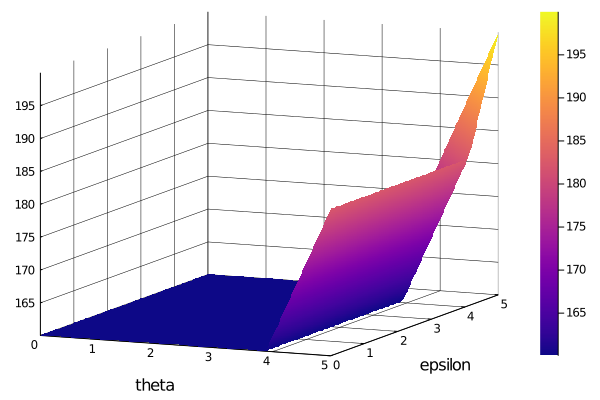

In [5]:
wp = CareerWorkerProblem()
v_init = fill(100.0, wp.N, wp.N)
func(x) = update_bellman(wp, x)
v = compute_fixed_point(func, v_init, max_iter = 500, verbose = false)

plot(linetype = :surface, wp.θ, wp.ϵ, transpose(v), xlabel="theta", ylabel="epsilon",
     seriescolor=:plasma, gridalpha = 1)

The optimal policy can be represented as follows (see [Exercise 3](#career-ex3) for code).


<a id='career-opt-pol'></a>
<img src="_static/figures/career_solutions_ex3_jl.png" style="width:100%;">

  
Interpretation:

- If both job and career are poor or mediocre, the worker will experiment with new job and new career.  
- If career is sufficiently good, the worker will hold it and experiment with new jobs until a sufficiently good one is found.  
- If both job and career are good, the worker will stay put.  


Notice that the worker will always hold on to a sufficiently good career, but not necessarily hold on to even the best paying job.

The reason is that high lifetime wages require both variables to be large, and
the worker cannot change careers without changing jobs.

- Sometimes a good job must be sacrificed in order to change to a better career.  

## Exercises


<a id='career-ex1'></a>

### Exercise 1

Using the default parameterization in the `CareerWorkerProblem`,
generate and plot typical sample paths for $ \theta $ and $ \epsilon $
when the worker follows the optimal policy.

In particular, modulo randomness, reproduce the following figure (where the horizontal axis represents time)

<img src="_static/figures/career_solutions_ex1_jl.png" style="width:100%;">

  
Hint: To generate the draws from the distributions $ F $ and $ G $, use the type [DiscreteRV](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/discrete_rv.jl).


<a id='career-ex2'></a>

### Exercise 2

Let’s now consider how long it takes for the worker to settle down to a
permanent job, given a starting point of $ (\theta, \epsilon) = (0, 0) $.

In other words, we want to study the distribution of the random variable

$$
T^* := \text{the first point in time from which the worker's job no longer changes}
$$

Evidently, the worker’s job becomes permanent if and only if $ (\theta_t, \epsilon_t) $ enters the
“stay put” region of $ (\theta, \epsilon) $ space.

Letting $ S $ denote this region, $ T^* $ can be expressed as the
first passage time to $ S $ under the optimal policy:

$$
T^* := \inf\{t \geq 0 \,|\, (\theta_t, \epsilon_t) \in S\}
$$

Collect 25,000 draws of this random variable and compute the median (which should be about 7).

Repeat the exercise with $ \beta=0.99 $ and interpret the change.


<a id='career-ex3'></a>

### Exercise 3

As best you can, reproduce [the figure showing the optimal policy](#career-opt-pol).

Hint: The `get_greedy()` method returns a representation of the optimal
policy where values 1, 2 and 3 correspond to “stay put”, “new job” and “new life” respectively. Use this and the plots functions (e.g., `contour, contour!`) to produce the different shadings.

Now set `G_a = G_b = 100` and generate a new figure with these parameters.  Interpret.

## Solutions

### Exercise 1

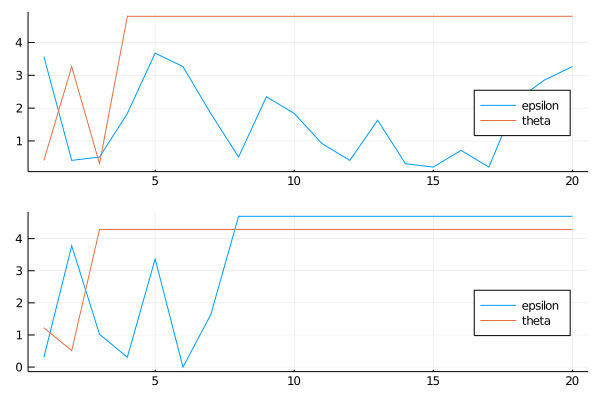

In [6]:
wp = CareerWorkerProblem()

function solve_wp(wp)
    v_init = fill(100.0, wp.N, wp.N)
    func(x) = update_bellman(wp, x)
    v = compute_fixed_point(func, v_init, max_iter = 500, verbose = false)
    optimal_policy = get_greedy(wp, v)
    return v, optimal_policy
end

v, optimal_policy = solve_wp(wp)

F = DiscreteRV(wp.F_probs)
G = DiscreteRV(wp.G_probs)

function gen_path(T = 20)
    i = j = 1
    θ_ind = Int[]
    ϵ_ind = Int[]

    for t=1:T
        # do nothing if stay put
        if optimal_policy[i, j] == 2 # new job
            j = rand(G)[1]
        elseif optimal_policy[i, j] == 3 # new life
            i, j = rand(F)[1], rand(G)[1]
        end
        push!(θ_ind, i)
        push!(ϵ_ind, j)
    end
    return wp.θ[θ_ind], wp.ϵ[ϵ_ind]
end

plot_array = Any[]
for i in 1:2
    θ_path, ϵ_path = gen_path()
    plt = plot(ϵ_path, label="epsilon")
    plot!(plt, θ_path, label="theta")
    plot!(plt, legend=:bottomright)
    push!(plot_array, plt)
end
plot(plot_array..., layout = (2,1))

### Exercise 2

The median for the original parameterization can be computed as follows

In [7]:
function gen_first_passage_time(optimal_policy)
    t = 0
    i = j = 1
    while true
        if optimal_policy[i, j] == 1 # Stay put
            return t
        elseif optimal_policy[i, j] == 2 # New job
            j = rand(G)[1]
        else # New life
            i, j = rand(F)[1], rand(G)[1]
        end
        t += 1
    end
end


M = 25000
samples = zeros(M)
for i in 1:M
    samples[i] = gen_first_passage_time(optimal_policy)
end
print(median(samples))

7.0

To compute the median with $ \beta=0.99 $ instead of the default value $ \beta=0.95 $, replace `wp=CareerWorkerProblem()` with `wp=CareerWorkerProblem(β=0.99)`.

The medians are subject to randomness, but should be about 7 and 14 respectively. Not surprisingly, more patient workers will wait longer to settle down to their final job.

In [8]:
wp2 = CareerWorkerProblem(β=0.99)

v2, optimal_policy2 = solve_wp(wp2)

samples2 = zeros(M)
for i in 1:M
    samples2[i] = gen_first_passage_time(optimal_policy2)
end
print(median(samples2))

14.0

### Exercise 3

Here’s the code to reproduce the original figure

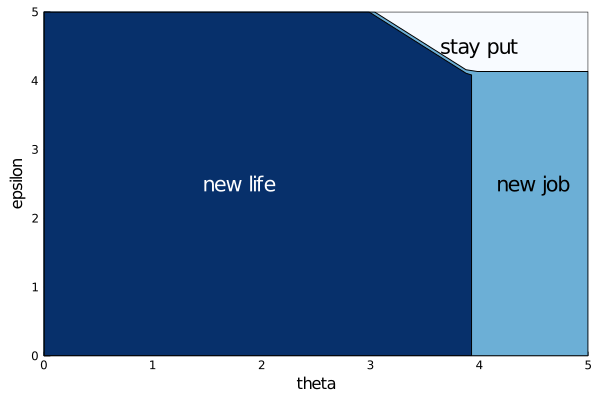

In [9]:
wp = CareerWorkerProblem();
v, optimal_policy = solve_wp(wp)

lvls = [0.5, 1.5, 2.5, 3.5]
x_grid = range(0, 5, length = 50)
y_grid = range(0, 5, length = 50)

contour(x_grid, y_grid, optimal_policy', fill=true, levels=lvls,color = :Blues,
        fillalpha=1, cbar = false)
contour!(xlabel="theta", ylabel="epsilon")
annotate!([(1.8,2.5, text("new life", 14, :white, :center))])
annotate!([(4.5,2.5, text("new job", 14, :center))])
annotate!([(4.0,4.5, text("stay put", 14, :center))])

Now, we need only swap out for the new parameters

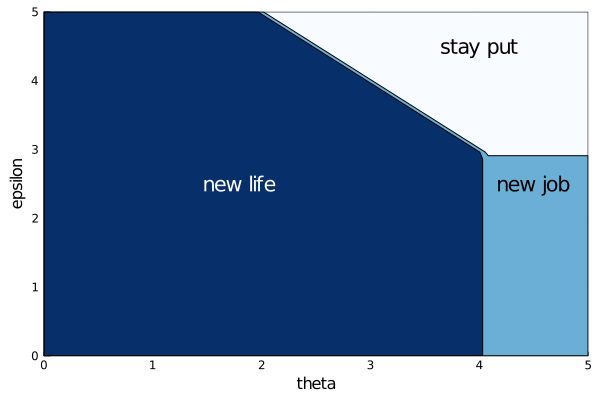

In [10]:
wp = CareerWorkerProblem(G_a=100.0, G_b=100.0); # use new params
v, optimal_policy = solve_wp(wp)

lvls = [0.5, 1.5, 2.5, 3.5]
x_grid = range(0, 5, length = 50)
y_grid = range(0, 5, length = 50)

contour(x_grid, y_grid, optimal_policy', fill=true, levels=lvls,color = :Blues,
        fillalpha=1, cbar = false)
contour!(xlabel="theta", ylabel="epsilon")
annotate!([(1.8,2.5, text("new life", 14, :white, :center))])
annotate!([(4.5,2.5, text("new job", 14, :center))])
annotate!([(4.0,4.5, text("stay put", 14, :center))])

You will see that the region for which the worker
will stay put has grown because the distribution for $ \epsilon $
has become more concentrated around the mean, making high-paying jobs
less realistic.